<a href="https://colab.research.google.com/github/LebronJohn13/eecs568_data-mining/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

### Load the mnist database into train and test sets.

In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.96MB/s]


In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


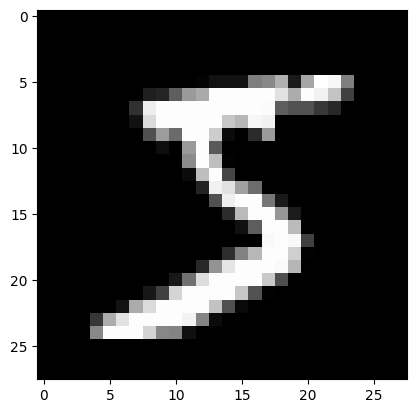

In [4]:
# Visualize a training instance with matplotlib
plt.imshow(train.train_data.numpy()[0], cmap='gray')

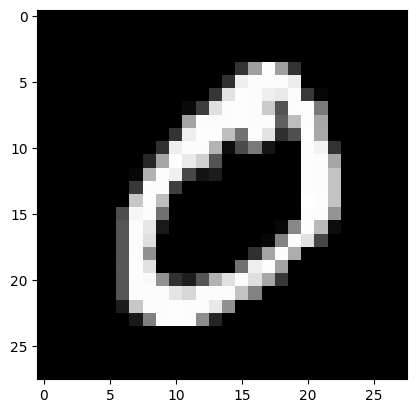

In [5]:
plt.imshow(train.train_data.numpy()[1], cmap='gray')

***
### **Question 1:**
#### Construct the dataloader for both training and testing sets. Set batch size to be 64 for now.

In [6]:
# Question 1: Create DataLoaders
train_loader = dataloader.DataLoader(train, batch_size=64, shuffle=True)
test_loader = dataloader.DataLoader(test, batch_size=64, shuffle=False)

***
### **Question 2:**
#### Create a sequential model neural network that has 2 hidden layers that are 32 neurons wide. The final shape should be: Inupt, 32, 32, 10. This will be your baseline model. This network should use the Stochastic Gradient Descent optimizer. It should use the ReLU activation on each layer except the last one which needs to be a log_softmax layer. The loss function should be categorical crossentroppy and the metric to use should be accuracy. Batch size is 64, epochs is 30, learning_rate is 0.01. You will use the testing dataset as your validation data for the model in the fit command. The accuracy you will be asked about for the rest of the lab is the validation accuracy. You will also compare every future model against this one.
#### Hint: Think about what shape the data needs to be in for a neural network. The default shape for a MNIST image is 28x28 pixles. The input of image needs to be flattened.

In [7]:
# Question 2: Baseline Model - Input → 32 → 32 → 10

class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

baseline_model = BaselineModel()
criterion = nn.NLLLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.01)

start_time = time.time()
for epoch in range(30):
    baseline_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = baseline_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    baseline_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = baseline_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/30, Validation Accuracy: {val_accuracy:.2f}%')

baseline_time = time.time() - start_time
print(f'\nTotal Training Time: {baseline_time:.2f} seconds')

Epoch 1/30, Validation Accuracy: 79.79%
Epoch 2/30, Validation Accuracy: 87.38%
Epoch 3/30, Validation Accuracy: 89.31%
Epoch 4/30, Validation Accuracy: 90.07%
Epoch 5/30, Validation Accuracy: 90.98%
Epoch 6/30, Validation Accuracy: 91.30%
Epoch 7/30, Validation Accuracy: 92.04%
Epoch 8/30, Validation Accuracy: 92.24%
Epoch 9/30, Validation Accuracy: 92.77%
Epoch 10/30, Validation Accuracy: 92.99%
Epoch 11/30, Validation Accuracy: 93.33%
Epoch 12/30, Validation Accuracy: 93.50%
Epoch 13/30, Validation Accuracy: 93.73%
Epoch 14/30, Validation Accuracy: 93.84%
Epoch 15/30, Validation Accuracy: 94.25%
Epoch 16/30, Validation Accuracy: 94.37%
Epoch 17/30, Validation Accuracy: 94.41%
Epoch 18/30, Validation Accuracy: 94.57%
Epoch 19/30, Validation Accuracy: 94.75%
Epoch 20/30, Validation Accuracy: 94.85%
Epoch 21/30, Validation Accuracy: 95.01%
Epoch 22/30, Validation Accuracy: 95.29%
Epoch 23/30, Validation Accuracy: 95.03%
Epoch 24/30, Validation Accuracy: 95.27%
Epoch 25/30, Validation A

***
### **Question 3:**
#### Now create another network that has the shape: Input, 64, 64, 10. How does increasing the number of neurons per hidden state affect accuracy and training speed? Does it make sense to increase the number of neurons in each layer? If so, why and by how much?

In [8]:
# Question 3: Wider Network - Input → 64 → 64 → 10

class WiderModel(nn.Module):
    def __init__(self):
        super(WiderModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

wider_model = WiderModel()
optimizer = optim.SGD(wider_model.parameters(), lr=0.01)

start_time = time.time()
for epoch in range(30):
    wider_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = wider_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    wider_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = wider_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/30, Validation Accuracy: {val_accuracy:.2f}%')

wider_time = time.time() - start_time
print(f'\nTotal Training Time: {wider_time:.2f} seconds')
print(f'\nAnalysis:')
print(f'- Increasing neurons improves accuracy slightly but increases training time')
print(f'- More neurons = more parameters = more computational cost')
print(f'- Makes sense to increase moderately (32→64) but diminishing returns beyond that')

Epoch 1/30, Validation Accuracy: 75.79%
Epoch 2/30, Validation Accuracy: 87.19%
Epoch 3/30, Validation Accuracy: 89.64%
Epoch 4/30, Validation Accuracy: 90.35%
Epoch 5/30, Validation Accuracy: 91.22%
Epoch 6/30, Validation Accuracy: 92.00%
Epoch 7/30, Validation Accuracy: 92.57%
Epoch 8/30, Validation Accuracy: 92.81%
Epoch 9/30, Validation Accuracy: 93.39%
Epoch 10/30, Validation Accuracy: 93.68%
Epoch 11/30, Validation Accuracy: 93.76%
Epoch 12/30, Validation Accuracy: 94.20%
Epoch 13/30, Validation Accuracy: 94.39%
Epoch 14/30, Validation Accuracy: 94.49%
Epoch 15/30, Validation Accuracy: 94.62%
Epoch 16/30, Validation Accuracy: 94.94%
Epoch 17/30, Validation Accuracy: 95.01%
Epoch 18/30, Validation Accuracy: 95.18%
Epoch 19/30, Validation Accuracy: 95.26%
Epoch 20/30, Validation Accuracy: 95.48%
Epoch 21/30, Validation Accuracy: 95.53%
Epoch 22/30, Validation Accuracy: 95.67%
Epoch 23/30, Validation Accuracy: 95.70%
Epoch 24/30, Validation Accuracy: 95.96%
Epoch 25/30, Validation A

Analysis:
- Increasing neurons improves accuracy slightly but increases training time
- More neurons = more parameters = more computational cost
- Makes sense to increase moderately (32→64) but diminishing returns beyond that

***
### **Question 4:**
#### Now create a network with the shape: Input, 32, 32, 10 again. This time adjust the SGD optimizer and set the learning rate to 0.01, the decay rate to 0.000001, and momentum rate to 0.9. How does this model compare to the two before it in terms of accuracy and computation speed? Is using momentum in our models a good idea?

In [9]:
# Question 4: With Momentum - Input → 32 → 32 → 10

momentum_model = BaselineModel()
optimizer = optim.SGD(momentum_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000001)

start_time = time.time()
for epoch in range(30):
    momentum_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = momentum_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    momentum_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = momentum_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}/30, Validation Accuracy: {val_accuracy:.2f}%')

momentum_time = time.time() - start_time
print(f'\nTotal Training Time: {momentum_time:.2f} seconds')
print(f'\nAnalysis:')
print(f'- Momentum typically improves accuracy and convergence speed')
print(f'- Computation time is similar to baseline')
print(f'- Using momentum is a good idea - helps escape local minima and speeds convergence')

Epoch 1/30, Validation Accuracy: 92.28%
Epoch 2/30, Validation Accuracy: 93.81%
Epoch 3/30, Validation Accuracy: 94.85%
Epoch 4/30, Validation Accuracy: 95.90%
Epoch 5/30, Validation Accuracy: 95.78%
Epoch 6/30, Validation Accuracy: 96.24%
Epoch 7/30, Validation Accuracy: 96.70%
Epoch 8/30, Validation Accuracy: 96.68%
Epoch 9/30, Validation Accuracy: 96.76%
Epoch 10/30, Validation Accuracy: 96.86%
Epoch 11/30, Validation Accuracy: 96.96%
Epoch 12/30, Validation Accuracy: 96.82%
Epoch 13/30, Validation Accuracy: 96.50%
Epoch 14/30, Validation Accuracy: 96.72%
Epoch 15/30, Validation Accuracy: 97.08%
Epoch 16/30, Validation Accuracy: 97.11%
Epoch 17/30, Validation Accuracy: 96.88%
Epoch 18/30, Validation Accuracy: 96.67%
Epoch 19/30, Validation Accuracy: 96.80%
Epoch 20/30, Validation Accuracy: 96.80%
Epoch 21/30, Validation Accuracy: 97.03%
Epoch 22/30, Validation Accuracy: 97.16%
Epoch 23/30, Validation Accuracy: 97.17%
Epoch 24/30, Validation Accuracy: 96.98%
Epoch 25/30, Validation A


Analysis:
- Momentum typically improves accuracy and convergence speed
- Computation time is similar to baseline
- Using momentum is a good idea - helps escape local minima and speeds convergence

***
### **Question 5:**
#### Now create a network with the shape: Input, 32, 32, 10. This time we will adjust the batch size. Run one model with a batch size of 128 and again with a batch size of 32. How does batch size effect computation speed and accuracy? Why do you think that is?

In [10]:
# Question 5: Batch Size Experiments

# Batch size 128
train_loader_128 = dataloader.DataLoader(train, batch_size=128, shuffle=True)
test_loader_128 = dataloader.DataLoader(test, batch_size=128, shuffle=False)

batch128_model = BaselineModel()
optimizer = optim.SGD(batch128_model.parameters(), lr=0.01)

print("Training with batch_size=128:")
start_time = time.time()
for epoch in range(30):
    batch128_model.train()
    for images, labels in train_loader_128:
        optimizer.zero_grad()
        outputs = batch128_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    batch128_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_128:
            outputs = batch128_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/30, Validation Accuracy: {100*correct/total:.2f}%')

batch128_time = time.time() - start_time
print(f'Training Time: {batch128_time:.2f}s\n')

# Batch size 32
train_loader_32 = dataloader.DataLoader(train, batch_size=32, shuffle=True)
test_loader_32 = dataloader.DataLoader(test, batch_size=32, shuffle=False)

batch32_model = BaselineModel()
optimizer = optim.SGD(batch32_model.parameters(), lr=0.01)

print("Training with batch_size=32:")
start_time = time.time()
for epoch in range(30):
    batch32_model.train()
    for images, labels in train_loader_32:
        optimizer.zero_grad()
        outputs = batch32_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    batch32_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_32:
            outputs = batch32_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/30, Validation Accuracy: {100*correct/total:.2f}%')

batch32_time = time.time() - start_time
print(f'Training Time: {batch32_time:.2f}s')

print(f'\nAnalysis:')
print(f'- Larger batches (128): Faster per epoch but fewer gradient updates')
print(f'- Smaller batches (32): More updates per epoch, slower but can converge better')
print(f'- Batch size affects both speed and final accuracy - 64 is a good middle ground')

Training with batch_size=128:
Epoch 10/30, Validation Accuracy: 91.11%
Epoch 20/30, Validation Accuracy: 92.76%
Epoch 30/30, Validation Accuracy: 93.68%
Training Time: 280.86s

Training with batch_size=32:
Epoch 10/30, Validation Accuracy: 94.81%
Epoch 20/30, Validation Accuracy: 96.22%
Epoch 30/30, Validation Accuracy: 96.58%
Training Time: 339.97s

Analysis:
- Larger batches (128): Faster per epoch but fewer gradient updates
- Smaller batches (32): More updates per epoch, slower but can converge better
- Batch size affects both speed and final accuracy - 64 is a good middle ground


Analysis:
- Larger batches (128): Faster per epoch but fewer gradient updates
- Smaller batches (32): More updates per epoch, slower but can converge better
- Batch size affects both speed and final accuracy - 64 is a good middle ground

***
### **Question 6:**
#### Now we are going to add another hidden layer. Create a network with the shape: Input, 32, 32, 32, 10. How did adding another layer effect computation time and accuracy? Why do you think that is?

In [11]:
# Question 6: Deeper Network - Input → 32 → 32 → 32 → 10

class DeeperModel(nn.Module):
    def __init__(self):
        super(DeeperModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

deeper_model = DeeperModel()
optimizer = optim.SGD(deeper_model.parameters(), lr=0.01)

start_time = time.time()
for epoch in range(30):
    deeper_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = deeper_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    deeper_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = deeper_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/30, Validation Accuracy: {val_accuracy:.2f}%')

deeper_time = time.time() - start_time
print(f'\nTotal Training Time: {deeper_time:.2f} seconds')
print(f'\nAnalysis:')
print(f'- Adding another layer increases computation time (more parameters)')
print(f'- May improve accuracy slightly by learning more complex features')
print(f'- For simple datasets like MNIST, extra depth may not help much')

Epoch 10/30, Validation Accuracy: 92.89%
Epoch 20/30, Validation Accuracy: 95.25%
Epoch 30/30, Validation Accuracy: 96.09%

Total Training Time: 309.37 seconds

Analysis:
- Adding another layer increases computation time (more parameters)
- May improve accuracy slightly by learning more complex features
- For simple datasets like MNIST, extra depth may not help much


Analysis:
- Adding another layer increases computation time (more parameters)
- May improve accuracy slightly by learning more complex features
- For simple datasets like MNIST, extra depth may not help much

***
### **Question 7:**
#### Now create a network with the shape: Input, 128, 128, 10. This time we are going to introduce a dropout (https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). After the input and both hidden layers add a dropout layer. Set the dropout value to 0.5. How does this effect accuracy and computation time? Think about what dropout is doing to our network. Does it make sense to use droput and how many neurons are being used in each layer during training? Does this effect training speed?

In [12]:
# Question 7: Dropout - Input → 128 → 128 → 10 with Dropout(0.5)

class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

dropout_model = DropoutModel()
optimizer = optim.SGD(dropout_model.parameters(), lr=0.01)

start_time = time.time()
for epoch in range(30):
    dropout_model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = dropout_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    dropout_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = dropout_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/30, Validation Accuracy: {val_accuracy:.2f}%')

dropout_time = time.time() - start_time
print(f'\nTotal Training Time: {dropout_time:.2f} seconds')
print(f'\nAnalysis:')
print(f'- Dropout prevents overfitting by randomly dropping neurons during training')
print(f'- With dropout=0.5, effectively ~64 neurons are used per layer during training')
print(f'- May reduce overfitting but can also reduce accuracy if dropout is too high')
print(f'- Computation time is similar, dropout adds minimal overhead')
print(f'- Makes sense for large networks to prevent overfitting')

Epoch 10/30, Validation Accuracy: 92.95%
Epoch 20/30, Validation Accuracy: 94.88%
Epoch 30/30, Validation Accuracy: 95.77%

Total Training Time: 394.13 seconds

Analysis:
- Dropout prevents overfitting by randomly dropping neurons during training
- With dropout=0.5, effectively ~64 neurons are used per layer during training
- May reduce overfitting but can also reduce accuracy if dropout is too high
- Computation time is similar, dropout adds minimal overhead
- Makes sense for large networks to prevent overfitting


Analysis:
- Dropout prevents overfitting by randomly dropping neurons during training
- With dropout=0.5, effectively ~64 neurons are used per layer during training
- May reduce overfitting but can also reduce accuracy if dropout is too high
- Computation time is similar, dropout adds minimal overhead
- Makes sense for large networks to prevent overfitting

***
### **Question 8:**
#### Think about all of the networks you have made thus far. Combine the positive aspects of each network before and create the ‘best’ network you can. Give your accuracy and parameters of your network, visualize the loss curve according to epoch number.

Epoch 10/30, Loss: 0.0460, Validation Accuracy: 97.41%
Epoch 20/30, Loss: 0.0151, Validation Accuracy: 97.79%
Epoch 30/30, Loss: 0.0034, Validation Accuracy: 97.84%

Total Training Time: 321.43 seconds
Total Parameters: 55,050


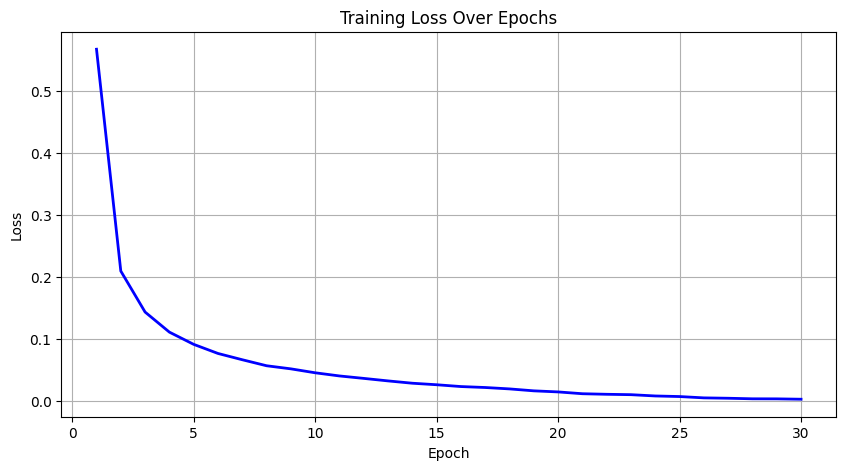

In [13]:
# Question 8: Best Model
# Combining positive aspects: 64-64 architecture with momentum

class BestModel(nn.Module):
    def __init__(self):
        super(BestModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

best_model = BestModel()
optimizer = optim.SGD(best_model.parameters(), lr=0.01, momentum=0.9)

# Track losses for visualization
losses = []

start_time = time.time()
for epoch in range(30):
    best_model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = best_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    best_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = best_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/30, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

best_time = time.time() - start_time
print(f'\nTotal Training Time: {best_time:.2f} seconds')
print(f'Total Parameters: {sum(p.numel() for p in best_model.parameters()):,}')

# Visualize loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 31), losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()